# Laplacian Associative Memory (LAM)

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)


In [980]:
import numpy as np
import matplotlib.pyplot as plt

In [981]:
# np.random.seed(123)

Weight Update:
w[ij] = w_E[ij] - (max(alpha) - alpha) * w_L[ij] - (1 + alpha) * w_G[ij]

Excitatory Weights:
w_E[ij] = (1/NV) * sum(memory.T * memory) * (max(alpha) * kronecker_delta + heteroassociative_matrix) * z[i] * z[j]

Local Inhibition Weights:
w_L[ij] = (1/NV) * sum(memory.T) * z[i] * z[j]

Global Inhibition Weights:
w_G[ij] = (P/NV) * ((1/P) * sum(memory.T) * z[i]) * ((1/P) * sum(memory) * z[j]) + ((1/N) * gamma)


z = memory


In [982]:
class LAM():
    def __init__(self, ndim):
        self.ndim = ndim
        self.weights = np.zeros((self.ndim, self.ndim))
        self.degree = np.zeros_like(self.weights)
        self.adjacency = np.zeros_like(self.weights)
        self.laplacian = np.zeros_like(self.weights)

    def train(self, data, threshold=0.1):
        for sample in data:
            memory = np.array([np.where(sample > threshold, 1, -1)]) # Binary dipole (+/-)
            delta_weights = memory.T * memory # Outer-product of the transpose
            self.weights += delta_weights # Update weights
            self.weights = (self.weights + self.weights.T) / 2 # Enforce symmetrical weights

        # Construct laplacian matrix
        self.degree = np.diag(np.sum(self.weights, axis=1)) # Degree of each vertex
        self.adjacency[np.abs(self.weights) > 0] = 1 # Normalized connectivity of network
        np.fill_diagonal(self.adjacency, 0) # Set diagonal to 0
        self.laplacian = self.degree - self.adjacency # Construct laplacian matrix (simple)

    def infer(self, state, iterations):
        for _ in range(iterations):
            idx = np.random.randint(self.ndim) # Select random neuron
            spin = np.dot(self.weights[idx,:], state) + self.laplacian[idx, idx] * state[idx] # Activation function
            state[idx] = self.step(spin)
        return state

    def step(self, x): # Step / Threshold activation function (Heaviside | Piecewise)
        return 1 if x > 0 else 0

    def sigmoid(self, x): # Continuous activation function
        return 1.0 / (1.0 + np.exp(-x))
    
    def kronecker_delta(i, j):
        return 1 if i==j else 0 

    def compute_energy(self, state): # As per original paper
        return -0.5 * np.dot(np.dot(self.weights, state), state.T)

In [983]:
# Hyperparameters
ndim = 16
memory = 2
p = 0.5
alpha = 0.1

In [991]:
data = np.random.choice([0, 1], size=ndim*memory, p=[p, 1 - p]) # Binary input with sparsity
data = data.reshape(memory, ndim)

print(data)
print(data.shape)

[[1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1]
 [0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1]]
(2, 16)


In [985]:
# Build model
model = LAM(ndim)

In [986]:
# Summary
w = int((ndim * (ndim - 1)) / 2)

print(ndim, "neurons")
print(w, "weighted connections")
print(f"{ndim * 0.138:.2f} point attactors")
print(f"{0.24 * w:.2f} bit capacity")

16 neurons
120 weighted connections
2.21 point attactors
28.80 bit capacity


In [987]:
# Train (Encoding)
model.train(data)

Text(0.5, 1.0, 'Laplacian')

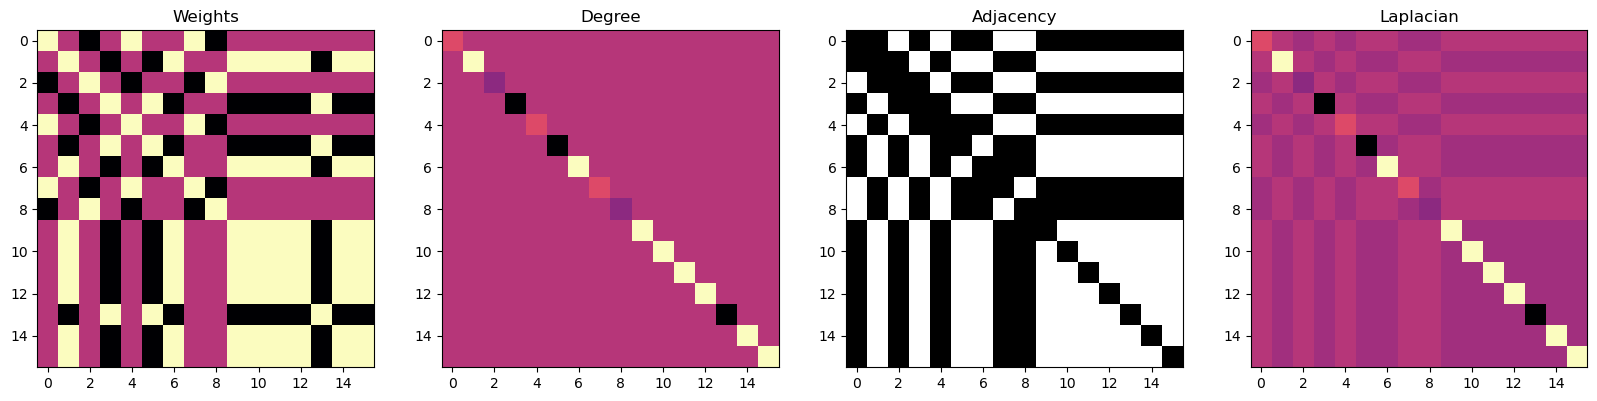

In [988]:
plt.figure(figsize=(20,60))
plt.subplot(1,4,1)
plt.imshow(model.weights, cmap='magma')
plt.title("Weights")

plt.subplot(1,4,2)
plt.imshow(model.degree, cmap='magma')
plt.title("Degree")

plt.subplot(1,4,3)
plt.imshow(model.adjacency, cmap='gray')
plt.title("Adjacency")

plt.subplot(1,4,4)
plt.imshow(model.laplacian, cmap='magma')
plt.title("Laplacian")

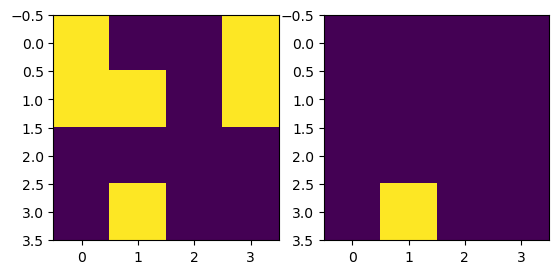

In [989]:
# state = np.random.randint(-1,2,(model.ndim)) # Noise

plt.subplot(1,2,1)
state = data[0]
plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)))

plt.subplot(1,2,2)
state[:8] = 0
plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)))

In [990]:
# Infer (Retrieval)
steps = 1000
n_update = 16
energy = []
T = 1.0

plt.figure(figsize=(20,200))
for i in range(steps):
    state = model.infer(state, n_update, T).astype(float)
    E = model.compute_energy(state)
    energy.append(E)

    noise = np.random.randint(-1,2, state.shape) * T * 0.1 # Add disturbance
    state += noise

    T = max(T * 0.99, 0.001) # Simulated annealing

    stamp = steps / 5
    if i%stamp == 0:
        m = int((i/stamp)+1)
        plt.subplot(1, int(steps/stamp), m)
        plt.imshow(state.reshape(int(ndim**0.5),int(ndim**0.5)), cmap='binary')
        plt.title(i)
        plt.axis('off')

TypeError: infer() takes 3 positional arguments but 4 were given

<Figure size 2000x20000 with 0 Axes>

In [ ]:
x = np.arange(len(energy))
y = np.array(energy).squeeze()

plt.figure()
plt.plot(x, y)
plt.grid(axis='both', color='0.95')
plt.title('Inference energy consumption')
plt.xlabel('Time'), plt.ylabel('Energy')